In [1]:
!nvidia-smi

Sat Apr 23 16:27:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
USE_GPU = 1

In [3]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
# tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
  tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.8.0

Available GPU Devices:
  /physical_device:GPU:0 GPU

Visible GPU Devices:
  /physical_device:GPU:0 GPU


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import tensorflow as tf
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, ReLU, GlobalAveragePooling2D, Input

In [7]:
class_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
               'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
               'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
               'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
               'storagetanks', 'tenniscourt']

In [8]:
# Instantiate the ResNet50 model
conv_base =tf.keras.applications.resnet.ResNet50(input_shape=(256, 256, 3),
                          include_top=False,
                          weights='imagenet')

# freeze the layers
for layer in conv_base.layers:
  layer.trainable = False

names = []
for layer in conv_base.layers:
  names.append(layer.name)

names[-1] # getting the name of the last conv layer

last_layer = conv_base.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

inputs = Input(shape = (256, 256, 3))
x = conv_base(inputs)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a final softmax layer for classification
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, output)

last layer output shape:  (None, 8, 8, 2048)


In [9]:
os.chdir("drive/MyDrive/Challenge_dataset/")

In [10]:
model.load_weights('./checkpoints/my_checkpoint')

In [11]:
with open("test.npy", "rb") as f:
  X_val = np.load(f)
  y_val = np.load(f)


In [12]:
X_val = X_val / 255.0

In [13]:
classif_prob = model.predict(X_val)
pred_classes_argmax = np.argmax(classif_prob,axis=-1)

In [14]:
predicted_cls = pred_classes_argmax[0]
print("Predicted class:", predicted_cls)

Predicted class: 0


In [15]:
from tensorflow.keras.optimizers import RMSprop

# compile the model
model.compile(optimizer=RMSprop(lr=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
values = model.evaluate(X_val, y_val)
print("{}:{},{}:{}.".format(model.metrics_names[0],values[0],model.metrics_names[1],values[1]))

9/9 [==============================] - 3s 119ms/step - loss: 3.2318 - accuracy: 0.4167
loss:3.231823444366455,accuracy:0.4166666567325592.


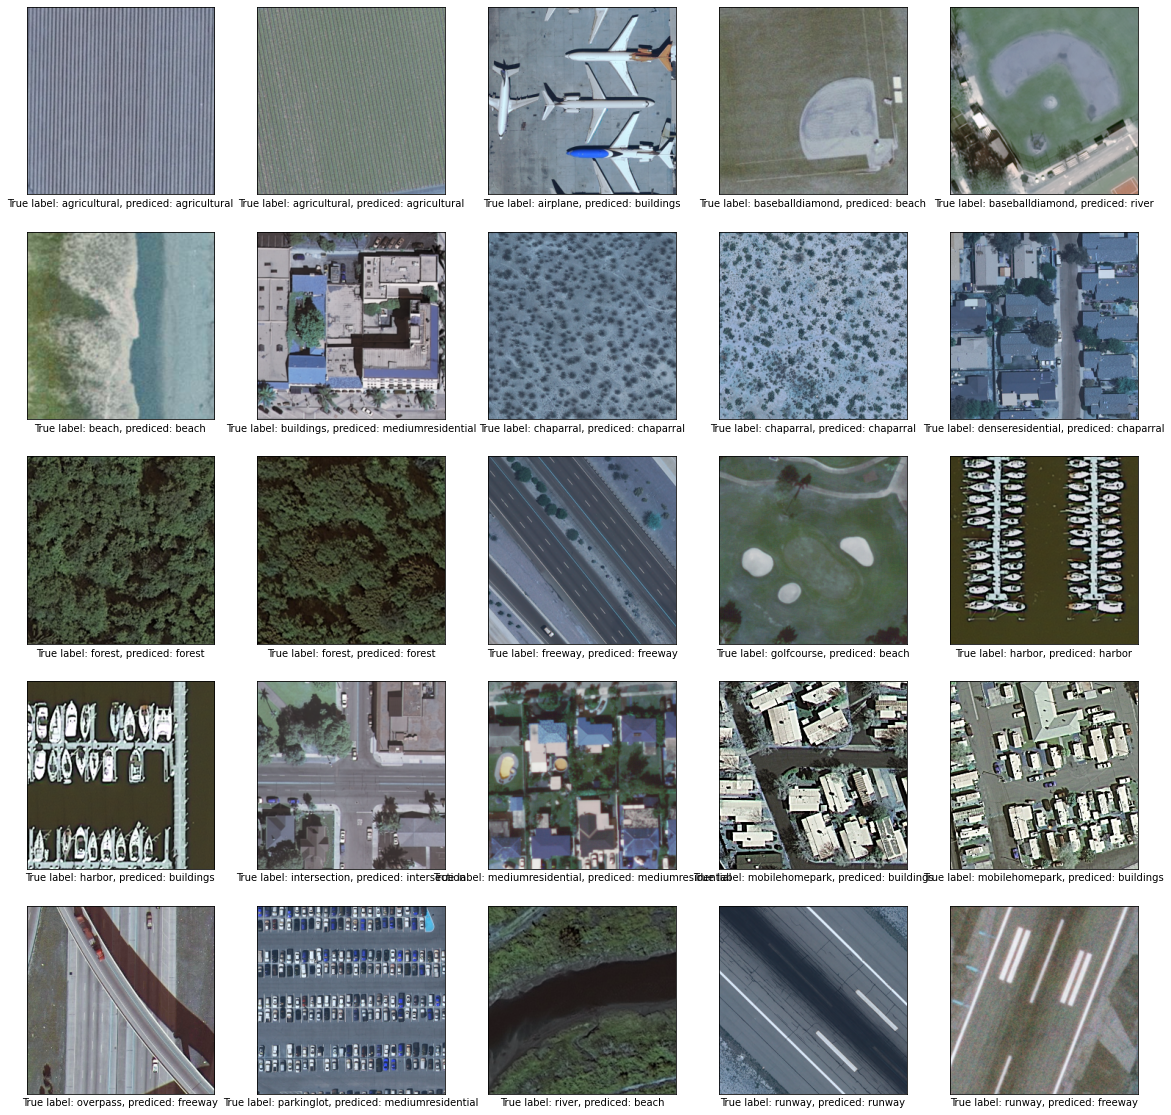

In [22]:
plt.figure(figsize=(20,20))
for i in range(0, 25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val[i*10])
    plt.xlabel("True label: " + class_names[y_val[i*10]] + ", prediced: " + class_names[pred_classes_argmax[i*10]])
plt.show()